<a href="https://colab.research.google.com/github/nadavo11/Hyperspectral-Target-detection-Debbies-cube/blob/main/Debbies_Cube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Debbie's Cube

This paper presents the results of an analysis of a hyper-spectral image, using the target implant algorithm. The study compares the values of the implanted target with the original data at multiple pixel locations and analyzes the impact on the data spectrum. The paper also includes generated histograms and ROC curves for the analysis, along with A values calculated for different thresholds. The aim of the document is to provide a detailed understanding of the target implant algorithm and its impact on the data spectrum, which can be useful for various applications such as target detection in remote sensing and image processing.

In [2]:


import pandas as pd
from matplotlib import pyplot as plt
import imageio
import numpy as np
from numpy.core.multiarray import dtype
import cv2

import spectral.io.envi as envi
from pathlib import Path

hdr_path = "bimodal.hdr"


In [3]:
! pip install spectral
import spectral as spec
from spectral.graphics.spypylab import imshow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 6.2 MB/s eta 0:00:00


In [86]:
def hyper_visualize(img):
    spec.imshow(img,(0,45,90),figsize = (7,7))
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

    axs[0, 0].imshow(img[:, :, 0], cmap='gray')
    axs[0, 0].set_title('Channel 1')
    axs[0, 1].imshow(img[:, :, 29], cmap='gray')
    axs[0, 1].set_title('Channel 30')
    axs[1, 0].imshow(img[:, :, 59], cmap='gray')
    axs[1, 0].set_title('Channel 60')
    axs[1, 1].imshow(img[:, :, 89], cmap='gray')
    axs[1, 1].set_title('Channel 90')

    #plt.tight_layout()
    plt.show()

# Load The Cube

In [32]:



header_file = str(hdr_path)
spectral_file = str('bimodal.dat')

numpy_ndarr = envi.open(header_file, spectral_file)

cube = numpy_ndarr.read_bands(range(91))  # select the bands

# Here, cube is an numpy nd-array

print(cube.shape)    # returns (100, 100, 3)


(50, 50, 91)


a $50\times50\times91$  hyperspectral cube means that we have a total of 91 channels of hight and width of 50 pixels

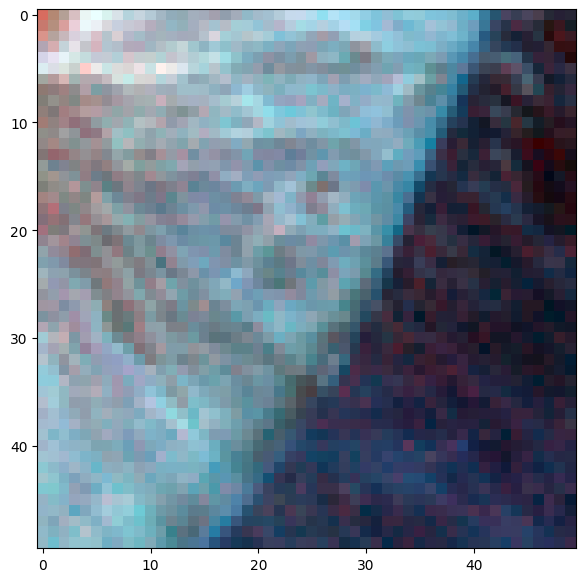

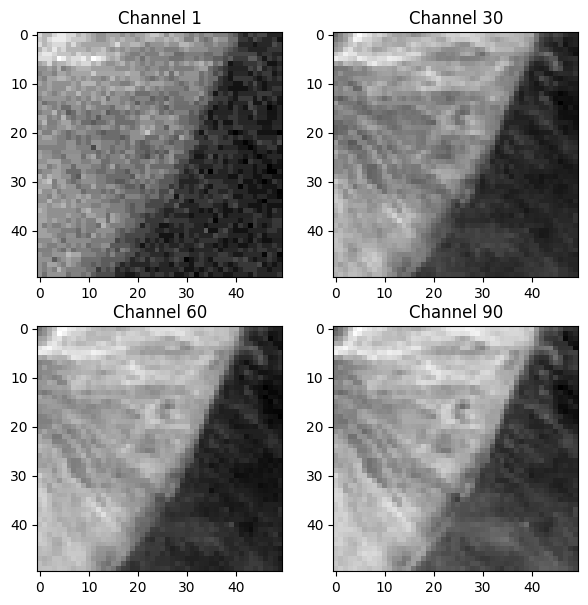

In [87]:
hyper_visualize(cube)

## Define our target, density, and treshold

In [8]:
#target's spectrum
t = cube[5,3,:]
#target's density
p= 0.1
#detection treshold
th = 0.1

# Calculate Cube's Statistics

## mean - $m$
Let's compute the statistic properties of a given 2D-pixel and its neighbors. We will first calculate the estimator, denoted as $m$, which is an estimation of the cube $x$. The estimator for every pixel is simply the mean of its immediate neighbors. Instead of calculating this directly using loops and addressing edge cases, we can compute this quite easily using convolution.

Let $X$ be a $3\times 3$ matrix of the given 2D-pixel and its neighbors. We can calculate the estimator $m$ as follows:

$m = \frac{1}{8}\sum\limits_{\substack{i=1 \ j=1}}^{3} X_{i,j} - \frac{1}{8} X_{2,2}$




​
 

Here, we convolve $X$ with a $3\times 3$ matrix $k= \frac{1}{8} \times \begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1
\end{bmatrix}$

 to obtain what we need. This is beneficial since we no longer have to take into account edge pixels, which have five neighbors, and corner pixels, which have only three neighbors. The only consideration for edges is dividing by the correct number of neighbors. We can accomplish this by using the function build_norm_mat that builds a normalizing matrix of the desired size.

In [9]:
from scipy import signal

def compute_m(cube):
    M = np.zeros(cube.shape)

    # Define kernel for convolution                                         
    kernel = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]]) 
    for c in range(M.shape[-1]):

        # Perform 2D convolution with input data and kernel 
        M[:,:,c] = signal.convolve2d(cube[:,:,c], kernel, boundary='wrap', mode='same')/8

    return M

M = compute_m(cube)
print (M.shape)


(50, 50, 91)


### visualize $m(i,j)$

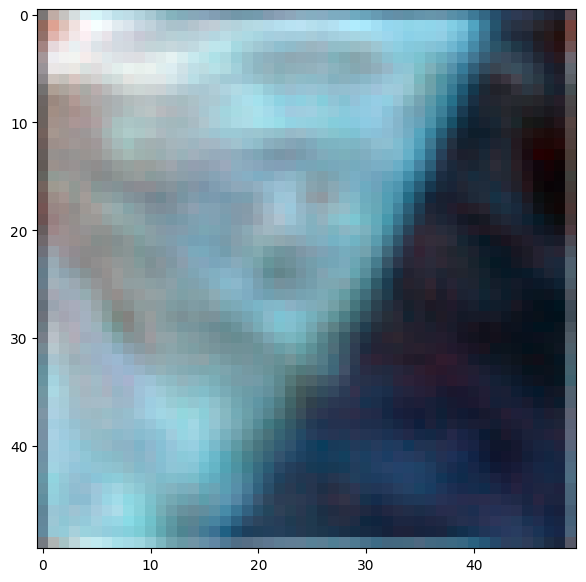

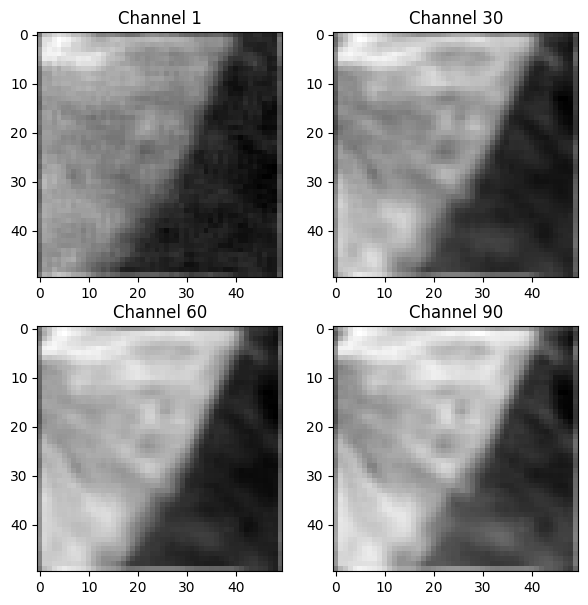

In [88]:
hyper_visualize(M)

#  Covariance Matrix - $\phi$
## Computing the Matrix
The covariance matrix we need is actually the auto-covariance matrix of the cube given by $\phi = E[ (X-m)·(X-m)^T]$

even though auto-covariance matrices are typically obtained from random vectors, not 3D matrices. However, in numpy, a random variable can be represented as a vector of samples from its distribution, which allows us to discuss statistical properties like mean and variance. Thus, a random vector can be a matrix where each row represents a single random variable. In our case, each of the 91 images in the cube is a random variable that has been sampled and organized into a matrix. 

so, if we concatenate the rows of each channel $c$ to form a $ 2500\times1 $ vector, we can represent the cube as a random vector of length 91. 

This new vector has the same statistical properties as the original images, and its auto-covariance matrix, sized 91x2500, is what we are looking for.





In [93]:
diff_estimator = cube - M


# Reshape X_MINUS_M to a 2D array of size (x_size*y_size) by num_of_bands
X,Y, n_bands = cube.shape
X_MINUS_M = np.reshape(diff_estimator, (X*Y, n_bands))

# Compute the covariance matrix of the reshaped array
phi = np.cov(X_MINUS_M, rowvar=False)

print(phi.shape)

(91, 91)


In [94]:
X_MINUS_M

array([[ 253.375,  210.125,  207.625, ...,  -42.   ,  -43.125,  -53.   ],
       [  14.375,   19.875,   39.   , ...,  -92.75 ,  -85.5  , -102.875],
       [   3.   ,   -8.25 ,   89.875, ...,  -70.75 ,  -72.375,  -71.5  ],
       ...,
       [  -3.125,   -4.75 ,  -36.   , ...,   34.75 ,   46.5  ,   43.   ],
       [   2.5  ,   -4.875,    3.   , ...,   46.   ,   34.   ,   31.   ],
       [ -76.625, -158.75 , -165.625, ...,  -92.   ,  -84.875,  -75.25 ]])

# Matched Filter

We are now ready to proceed with running the MF algorithm as intended. We will be running the algorithm twice per 90-entry-pixel $X(i,j)$ $i,j \in [0,50]$.

 Firstly, we will run the algorithm with no target (NT). Secondly, we will be planting a certain percentage of the target in each pixel (WT).

In [95]:
Matched_Filter_NT = np.zeros((X,Y))
Matched_Filter_WT = np.zeros((X,Y))


In [96]:
MF_coef = t @ np.linalg.inv(phi)
MF_coef.shape

(91,)

In [97]:
# no target
Matched_Filter_NT = MF_coef *diff_estimator
Matched_Filter_WT = MF_coef * (diff_estimator + p*t)

In [98]:
Matched_Filter_WT.shape


(50, 50, 91)

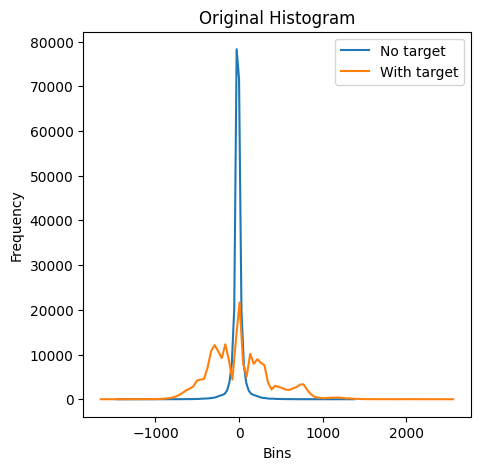

In [99]:
NT_val, NT_bins = np.histogram(Matched_Filter_NT, bins=100)
WT_val, WT_bins = np.histogram(Matched_Filter_WT, bins=100)

fig, ax = plt.subplots()
ax.plot(NT_bins[:-1], NT_val, label='No target')
ax.plot(WT_bins[:-1], WT_val, label='With target')
ax.set(title='Original Histogram', xlabel='Bins', ylabel='Frequency')
ax.legend()
fig.set_size_inches(5, 5)
plt.show()

In [100]:
a = np.array([[[1,2],[3,4]],[[1,2],[3,4]]])
b =np.array([-1,2]) 
a.shape
a*b


array([[[-1,  4],
        [-3,  8]],

       [[-1,  4],
        [-3,  8]]])

In [101]:
from scipy.integrate import cumtrapz


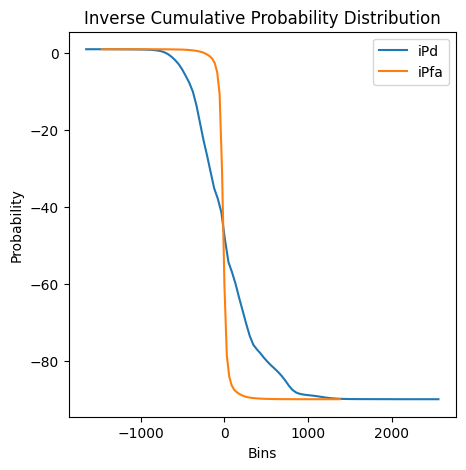

In [102]:
x_size = len(Matched_Filter_WT)
y_size = len(Matched_Filter_NT)
ipd = 1 - cumtrapz(WT_val, initial=0)/(X*Y)
ipfa = 1 - cumtrapz(NT_val, initial=0)/(X*Y)

fig, ax = plt.subplots()
ax.plot(WT_bins[:-1], ipd, label='iPd')
ax.plot(NT_bins[:-1], ipfa, label='iPfa')
ax.set(title='Inverse Cumulative Probability Distribution', xlabel='Bins', ylabel='Probability')
ax.legend()
fig.set_size_inches(5, 5)
plt.show()

In [103]:
print(t @ np.linalg.inv(phi))

[ 0.55413255  1.15916098  1.56299653  1.45440593  1.59510711  1.44289889
  1.38991888  0.77295523  0.56920833  0.81691315 -0.24465999 -0.26606059
 -0.90982527 -1.04440946 -0.452615   -0.57833524 -0.50311947 -0.33984546
  0.02878764 -0.13761507  0.07042874  0.56354223  0.52001948  0.25553164
 -0.78537322 -0.09516208 -0.82169717 -0.52574238 -0.67461254 -0.01623
 -0.33035419  0.28176378 -0.04509785 -0.22310728  0.41856543  0.05345081
 -0.8525436   0.22695519  0.06658083  0.91700924  0.6423115   0.51421617
  1.10120043  0.33162622  0.51351639  0.66353002  0.09592553  0.14707011
 -0.23265118  0.04344267 -0.00967947 -0.28107047 -0.6244922  -0.36357928
 -1.00282632 -2.14163136 -1.48359519 -1.67039585 -0.99916025 -1.68493332
 -1.58851666 -0.55971675 -2.31520171 -0.56537603 -0.7121032  -0.08750591
  0.09291939  1.00218001 -0.60650191  0.5328633   0.72492388  0.06054746
  0.32303642 -1.81900099 -1.2518272  -1.29605434 -0.04601353 -4.57321359
 -4.95320784 -3.72090782 -3.36949425  0.34776071  0.25

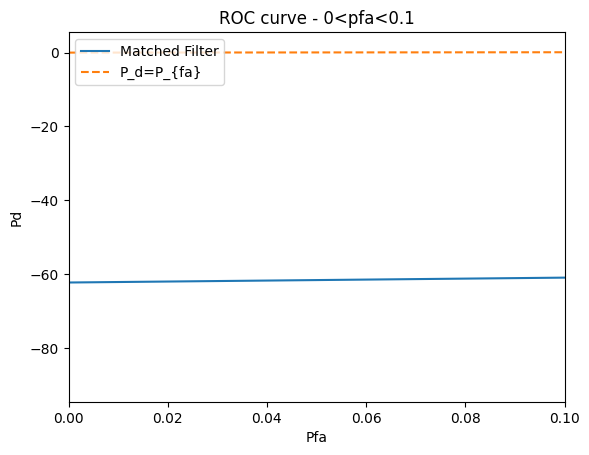

In [105]:
plt.figure()
plt.plot(ipfa, ipd)
plt.plot([0, th], [0, th], '--')
plt.title('ROC curve - 0<pfa<0.1')
plt.xlabel('Pfa')
plt.ylabel('Pd')
plt.legend(['Matched Filter', 'P_d=P_{fa}'], loc='upper left')
plt.xlim([0, th])
plt.show()